# Settings

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow_addons
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

#from patchfcn import PatchFCN
#from load_segmentation import *
#from patchify import *
from utilities import *
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

import cv2
import os
import tarfile
import tensorflow_datasets as tfds
import pickle
import matplotlib.pyplot as plt
import time

Mon Mar 20 04:18:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    34W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# IOU and CLAHE

In [5]:
SEED = 2022
DATA_SPLIT = 0.8

OPTIMIZER = keras.optimizers.Adam(learning_rate=1e-4)
LOSS = "binary_crossentropy"

def mean_iou(y_true, y_pred):
  y_pred = tf.where(y_pred>0.5, 1, 0)
  y_pred = tf.round(tf.cast(y_pred, tf.int32))
  intersect = tf.reduce_sum(tf.cast(y_true, tf.float32) * tf.cast(y_pred, tf.float32), axis=[1])
  union = tf.reduce_sum(tf.cast(y_true, tf.float32),axis=[1]) + tf.reduce_sum(tf.cast(y_pred, tf.float32),axis=[1])
  smooth = tf.ones(tf.shape(intersect))
  return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

def sec_accuracy(y_true, y_pred):
  y_pred = tf.where(y_pred>0.5, 1, 0)
  y_pred = tf.round(tf.cast(y_pred, tf.int32))
  y_true = tf.round(tf.cast(y_true, tf.int32))
  return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32))


METRICS = [sec_accuracy, mean_iou]
IMAGE_SHAPE = (512,512,1)
KFOLD  = 3 #MUST BE >=2
EPOCHS = 150
BATCH_SIZE = 4

In [6]:
def plot_metrics(history):
    fig, ax = plt.subplots(2, 2, figsize=(15,10), dpi=100, facecolor="white")
    axes = ax.ravel()
    axes[0].plot(history["loss"], label="Train Loss")
    axes[0].plot(history["val_loss"], label="Val Loss")
    axes[1].plot(history["mean_iou"], label="Train Mean IOU")
    axes[1].plot(history["val_mean_iou"], label="Val Mean IOU")
    axes[2].plot(history["sec_accuracy"], label="Train Accuracy")
    axes[2].plot(history["val_sec_accuracy"], label="Val Accuracy")
    for ax in axes[:3]:
        ax.legend(loc="best", fontsize=14)
        ax.set_xlabel("Epoch", fontsize=14)
        ax.grid(linestyle=":", alpha=0.25)
    axes[3].axis("off")

In [7]:
def class_metrics(x, y, class_dict, model):
  
  st = time.time()
  num_classes = len(class_dict)

  accs = []
  for idx in range(len(x)):
    xp = np.expand_dims(x[idx], axis=0)
    yp = model.predict(xp)
    yp_thresh = np.squeeze(np.where(yp>0, 1, 0))
    accs.append((y[idx] == yp_thresh).reshape(-1,num_classes).mean(axis=0))

  
  print("Mean: ", np.round(100*np.mean(accs), 2))
  accs = np.round(100*np.array(accs).mean(axis=0), 2)

  print("\n", list(class_dict.keys()), "\n", accs)

  et = time.time()
  print("\nTime: {:.2f} min {:.2f} sec".format((et-st)//60, (et-st)%60))

In [8]:
# USE FOR DEEPLAB AND UNET. WILL NOT WORK FOR PATCHFCN
def simple_viz(x, y, class_dict, model, idx, threshold=0.5):
  pred_y = np.squeeze(model.predict(np.expand_dims(x[idx], axis=0)))
  pred_y_thresh = np.where(pred_y>threshold, 1, 0)

  num_classes = len(class_dict)

  Labels = ["True Mask", "Raw Pred Mask", "Thresh Pred Mask"]

  fig, axes = plt.subplots(num_classes, 4, figsize=(20, 5*num_classes), facecolor="white")
  for i in range(0,num_classes):
    axes[i,0].axis("off")

  axes[0,0].imshow(np.squeeze(x[idx]), cmap="gray")
  for i in range(0,num_classes):
    axes[i,1].imshow(y[idx][:,:,i], cmap="gray")
  for i in range(0,num_classes):
    axes[i,2].imshow(pred_y[:,:,i], cmap="gray")
  for i in range(0,num_classes):
    axes[i,3].imshow(pred_y_thresh[:,:,i], cmap="gray")
  for j in range(1,4):
    axes[num_classes-1,j].set_xlabel(Labels[j-1], fontsize=14)

    class_names = list(class_dict.keys())
  for i in range(0, num_classes):
    axes[i,1].set_ylabel(class_names[i], fontsize=14)

In [9]:
def get_as_numpy_with_clahe(inputdata, kernel_size, clip_limit=5):
  fullX = []
  fullY = []

  clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=kernel_size)

  ds = [x for x in tfds.as_numpy(inputdata)]
  for batch in ds:
    for x in range(len(batch[0])):
      fullX.append(np.expand_dims(clahe.apply(np.squeeze(batch[0][x])), axis=-1))
    for y in range(len(batch[1])):
      fullY.append(batch[1][y])

  return fullX,fullY

# Model Fit

In [10]:
def split_learn(model_name, dataset_name, multi_class_flag, train_flag=True, with_clahe=False, clahe_kernels=None, clahe_clip_limit=None, repetitions=1, augmentations=(0,0,0,0,0,0)):

  if dataset_name == "tufts":
    dataPath = os.path.join("/content/drive/My Drive/BU Projects/DentalML/Data/TuftsData","Images")
    classfilePath = os.path.join("/content/drive/My Drive/BU Projects/DentalML/Data/TuftsData","multi_class.txt")
    dataType = "*.jpg"

  elif dataset_name == "peixi":
    dataPath = os.path.join("/content/drive/MyDrive/dental/data/Peixi","Images")
    classfilePath = os.path.join("/content/drive/MyDrive/dental/data/Peixi","multi_class.txt")
    dataType = "*.png"

  if multi_class_flag:
    with open(classfilePath, "w") as write_file:
      if dataset_name == "tufts": 
        write_file.write("Teeth\nJaw\nAbnormal")
      elif dataset_name == "peixi":
        write_file.write("Tooth\nBone\nRoot_Canal\nSinus\nMajor_Nerve\nRestoration")
    file_name = model_name + "_" + dataset_name + "_" + "multi"

  else:
    with open(classfilePath, "w") as write_file:
      if dataset_name == "tufts":
        write_file.write("Teeth")
      elif dataset_name == "peixi":
        write_file.write("Tooth")
    file_name = model_name + "_" + dataset_name + "_" + "single"
  
  file_name = file_name + "_" + "".join(map(str, augmentations))

  with open(classfilePath, "r") as read_file:
    print("Classes:")
    print(read_file.read())

  print("\nfile_name:\n", file_name, "\n")
  dataset,class_dict = generate_dataset(dataPath,
                                        dataType,
                                        seed=SEED,
                                        img_shape = IMAGE_SHAPE,
                                        batch_size = BATCH_SIZE,
                                        kfold = 1,
                                        repeat_count = repetitions,
                                        class_file = classfilePath,
                                        enable_augmentation = augmentations)
  
  if with_clahe:
    print("\nwith CLAHE\n")
    x, y = get_as_numpy_with_clahe(dataset[0], kernel_size=clahe_kernels, clip_limit=clahe_clip_limit)
  else:
    print("\nwithout CLAHE\n")
    x, y = get_as_numpy(dataset[0])

  x = np.array(x)
  y = np.array(y)

  print("Num files:", x.shape[0])

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-DATA_SPLIT, random_state=SEED)
  
  if model_name == "PatchFCN":
    x_train_patched, y_train_patched = get_patched(x_train, y_train)
    x_test_patched, y_test_patched = get_patched(x_test, y_test)

  if model_name == "PatchFCN":
    model = PatchFCN(input_shape = x_train_patched[0].shape, num_classes=len(class_dict))

  elif model_name =="DeepLab":
    if np.max(x_train)==255:
      x_train = x_train/255
      x_test = x_test/255
    model = DeepLabv3Plus(x_train[0].shape, num_classes=len(class_dict))

  elif model_name =="UNET":
    if np.max(x_train)==255:
      x_train = x_train/255
      x_test = x_test/255
    model = UNET(input_shape = x_train[0].shape, num_classes=len(class_dict))
  
  #loss = keras.losses.BinaryCrossentropy(from_logits=True)
  #loss2 = "categorical_crossentropy"

  if model_name == "PatchFCN" or model_name=="UNET":
    model.compile(optimizer = OPTIMIZER, 
                loss = LOSS,
                metrics = METRICS)

  elif model_name =="DeepLab":
    model.compile(optimizer = OPTIMIZER, 
                  loss = LOSS,
                  metrics = METRICS)
  
  def alpha_changer(epoch,lr):
    if (epoch%50==0):
      return lr/10.0
    return lr

  ac = tf.keras.callbacks.LearningRateScheduler(alpha_changer)
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


  if train_flag:

    print("\nim shape\n", x_train.shape, " - ", x_test.shape, " - ", y_train.shape, " - ", y_test.shape)

    if model_name == "PatchFCN":
      history = model.fit(x_train_patched, 
                          y_train_patched,
                          batch_size = BATCH_SIZE,
                          validation_data=(x_test_patched, y_test_patched),
                          epochs = EPOCHS,
                          verbose = 2,
                          callbacks=[ac])
      
    elif model_name == "DeepLab" or model_name == "UNET":
      history = model.fit(x_train, 
                          y_train,
                          batch_size = BATCH_SIZE,
                          validation_data=(x_test, y_test),
                          epochs = EPOCHS,
                          verbose = 2,
                          callbacks=[ac])
    
  
  else:
    # LOAD WEIGHTS HERE
    history=[]
    print("NO TRAIN")
  
  return model, history.history, x_train, y_train, x_test, y_test, class_dict

In [11]:
IMAGE_SHAPE = (512, 512, 1)
EPOCHS = 100

# Unet

In [ ]:
from unet import *

In [ ]:
model_peixi, history_peixi, xtr_peixi, ytr_peixi, xte_peixi, yte_peixi, dict_peixi = split_learn("UNET", 
                                                                                     "peixi", 
                                                                                     multi_class_flag=1,
                                                                                     train_flag=True,
                                                                                     with_clahe=True,
                                                                                     clahe_kernels=(28,28),
                                                                                     clahe_clip_limit=5,
                                                                                     repetitions=1, 
                                                                                     augmentations=(0,0,0,0,0,0))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Classes:
Tooth
Bone
Root_Canal
Sinus
Major_Nerve
Restoration

file_name:
 UNET_peixi_multi_000000 

{'Tooth': 0, 'Bone': 1, 'Root_Canal': 2, 'Sinus': 3, 'Major_Nerve': 4, 'Restoration': 5}
no image augmentaton

with CLAHE

Num files: 41
softmax

im shape
 (32, 512, 512, 1)  -  (9, 512, 512, 1)  -  (32, 512, 512, 6)  -  (9, 512, 512, 6)
Epoch 1/100
8/8 - 34s - loss: 0.7818 - sec_accuracy: 0.8409 - mean_iou: 0.2179 - val_loss: 0.7541 - val_sec_accuracy: 0.8360 - val_mean_iou: 0.3426 - lr: 1.0000e-05 - 34s/epoch - 4s/step
Epoch 2/100
8/8 - 5s - loss: 0.7691 - sec_accuracy: 0.8410 - mean_iou: 0.2228 - val_loss: 0.7363 - val_sec_accuracy: 0.8359 - val_mean_iou: 0.3428 - lr: 1.0000e-05 - 5s/epoch - 686ms/step
Epoch 3/100
8/8 - 6s - loss: 0.7563 - sec_accuracy: 0.8413 - mean_iou: 0.2272 - val_loss: 0.7205 - val_sec_accuracy: 0.8359 - val_mean_iou: 0.3429 - lr: 1.0000e-05 - 6s/epoch - 718ms/step
Epoch 4/100
8/8 - 6s - loss: 0.7443 - sec_accuracy: 0.8415 - mean_iou: 0.2320 - val_loss: 0.7066 - 

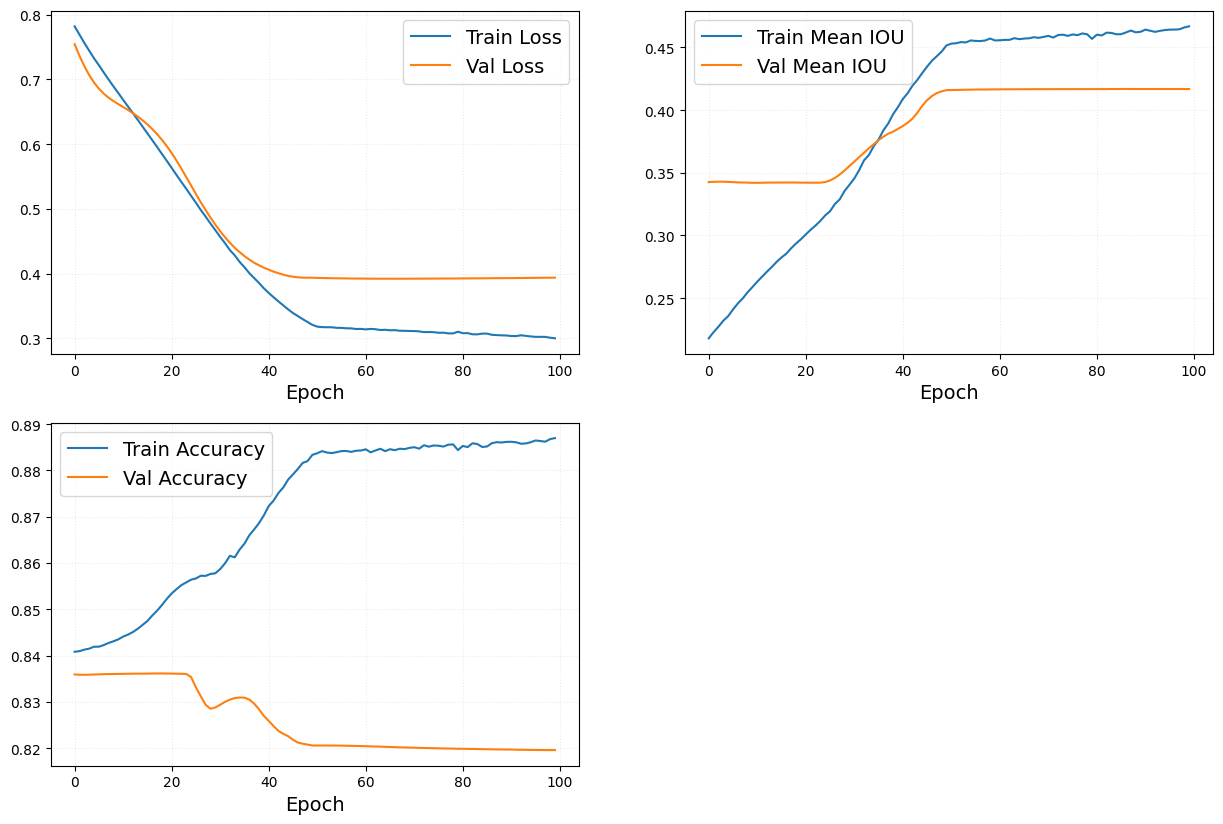

In [ ]:
plot_metrics(history_peixi)

In [ ]:
cls = ['Tooth', 'Bone', 'Root', 'Sinus', 'Nerve', 'Restoration']

1/1 [==============================] - 0s 93ms/step


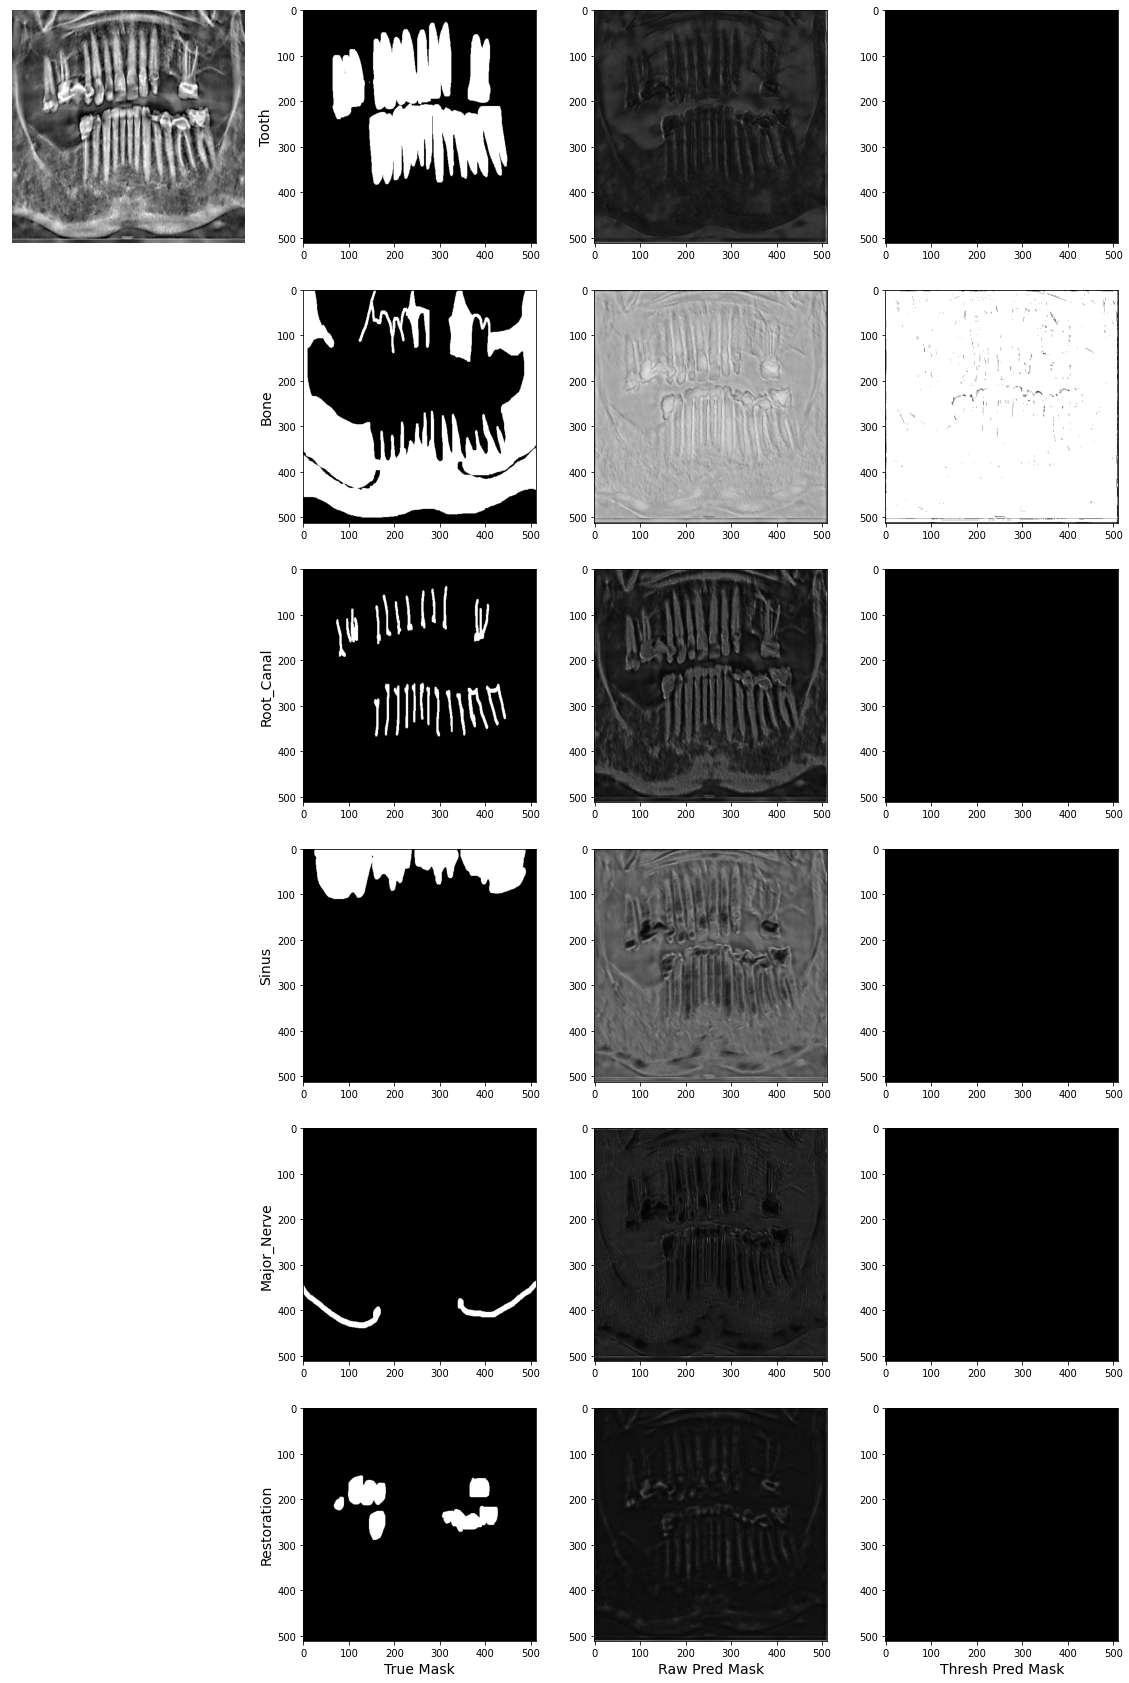

In [ ]:
simple_viz(xte_peixi, yte_peixi, dict_peixi, model_peixi, 6, threshold=0.5)

# PatchFCN

In [12]:
from patchfcn import *

In [13]:
model_peixi, history_peixi, xtr_peixi, ytr_peixi, xte_peixi, yte_peixi, dict_peixi = split_learn("PatchFCN", 
                                                                                     "peixi", 
                                                                                     multi_class_flag=1,
                                                                                     train_flag=True,
                                                                                     with_clahe=True,
                                                                                     clahe_kernels=(28,28),
                                                                                     clahe_clip_limit=5,
                                                                                     repetitions=1, 
                                                                                     augmentations=(0,0,0,0,0,0))

Classes:
Tooth
Bone
Root_Canal
Sinus
Major_Nerve
Restoration

file_name:
 PatchFCN_peixi_multi_000000 

{'Tooth': 0, 'Bone': 1, 'Root_Canal': 2, 'Sinus': 3, 'Major_Nerve': 4, 'Restoration': 5}
no image augmentaton


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089



with CLAHE

Num files: 41
(832, 224, 224, 1)
Patching done
(234, 224, 224, 1)
Patching done

im shape
 (32, 512, 512, 1)  -  (9, 512, 512, 1)  -  (32, 512, 512, 6)  -  (9, 512, 512, 6)
Epoch 1/100
208/208 - 53s - loss: 0.5962 - sec_accuracy: 0.6740 - mean_iou: 0.1340 - val_loss: 0.4526 - val_sec_accuracy: 0.7839 - val_mean_iou: 0.2258 - lr: 1.0000e-05 - 53s/epoch - 253ms/step
Epoch 2/100
208/208 - 32s - loss: 0.4099 - sec_accuracy: 0.8101 - mean_iou: 0.3178 - val_loss: 0.3880 - val_sec_accuracy: 0.8173 - val_mean_iou: 0.3753 - lr: 1.0000e-05 - 32s/epoch - 156ms/step
Epoch 3/100
208/208 - 34s - loss: 0.3851 - sec_accuracy: 0.8214 - mean_iou: 0.4026 - val_loss: 0.3783 - val_sec_accuracy: 0.8212 - val_mean_iou: 0.4284 - lr: 1.0000e-05 - 34s/epoch - 163ms/step
Epoch 4/100
208/208 - 32s - loss: 0.3763 - sec_accuracy: 0.8248 - mean_iou: 0.4440 - val_loss: 0.3727 - val_sec_accuracy: 0.8237 - val_mean_iou: 0.4615 - lr: 1.0000e-05 - 32s/epoch - 154ms/step
Epoch 5/100
208/208 - 32s - loss: 0.37

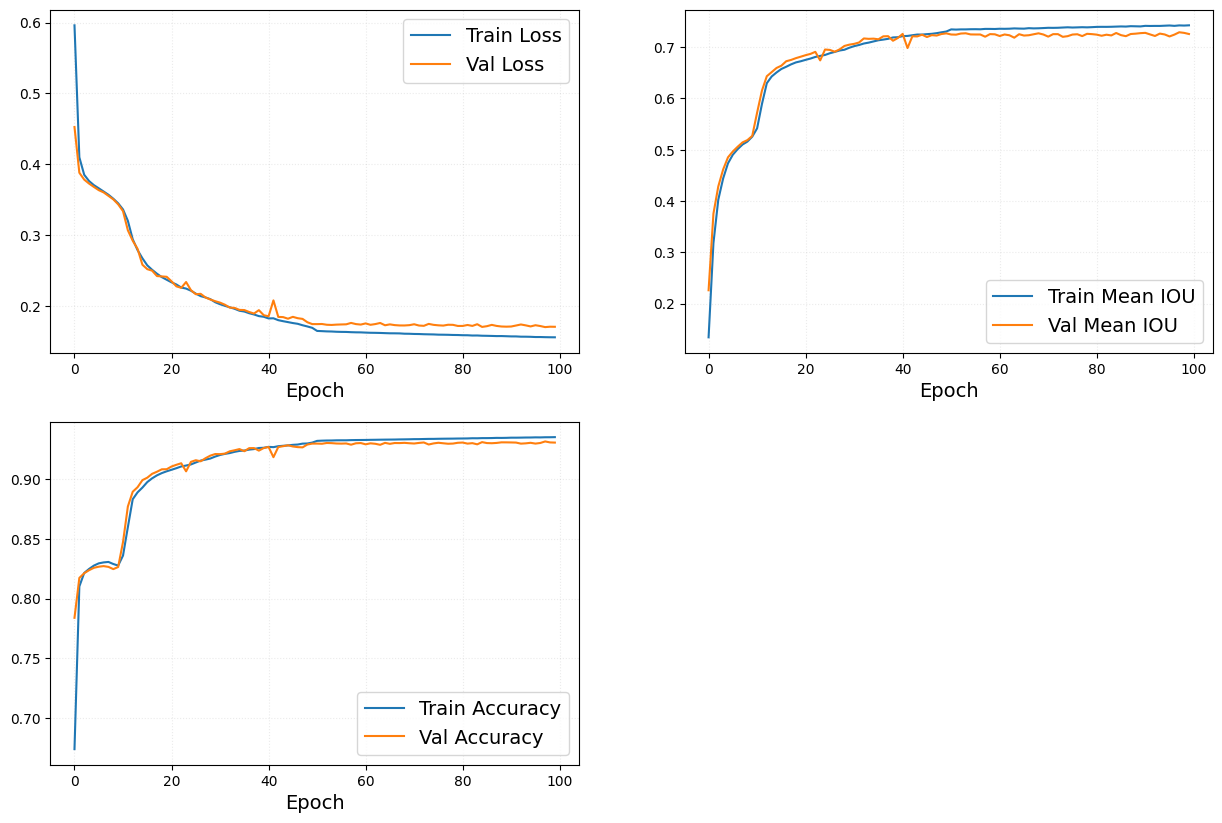

In [14]:
plot_metrics(history_peixi)

In [16]:
simple_viz(xte_peixi, yte_peixi, dict_peixi, model_peixi, 7, threshold=0.5)

ValueError: ignored